In [1]:
# === Core libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# === LRF core model and training ===
from lrf import fit_lrf_model, get_default_strategy, simulate_rdii
from lrf.train import get_default_model_config
from lrf.response import compute_kappa, time_dependent_response
# === Utilities and metrics ===
from lrf.utils import (
    calculate_r2,
    calculate_kge,
    build_param_dict,
    print_param_dict,
    plot_response_at_saturation_levels
)

In [2]:
data= pd.read_excel('example_data.xlsx', index_col=0)
data.index = pd.to_datetime(data.index)
# === Convert to NumPy arrays ===
x = data['R'].to_numpy()
y = data['RDII'].to_numpy()
# === Normalize input and output variables ===
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
x_normalized = (x - x_min) / (x_max - x_min)
y_normalized = (y - y_min) / (y_max - y_min)
# === Split dataset into training and testing sets ===
time_steps = len(x_normalized)
train_size = int(0.6 * time_steps)
rainfall_train, rainfall_test = x_normalized[:train_size], x_normalized[train_size:]
rdii_train, rdii_test = y_normalized[:train_size], y_normalized[train_size:]

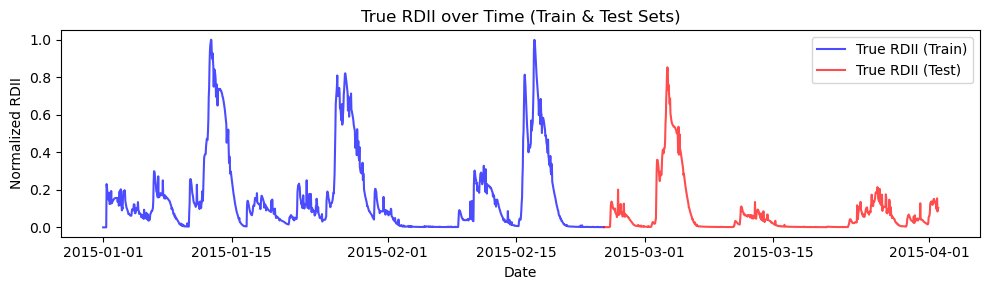

In [3]:
# === Extract corresponding time index for train/test sets ===
time_index = data.index  
train_time = time_index[:train_size]
test_time = time_index[train_size:]

# === Plot normalized true RDII values for train and test sets ===
plt.figure(figsize=(10, 3))
plt.plot(train_time, rdii_train, label="True RDII (Train)", color="blue", alpha=0.7)
plt.plot(test_time, rdii_test, label="True RDII (Test)", color="red", alpha=0.7)
# === Plot formatting ===
plt.xlabel("Date")
plt.ylabel("Normalized RDII")
plt.title("True RDII over Time (Train & Test Sets)")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# === Load default model structure and initialization ===
# The following default values define the initial configuration of the model,
# including the number of B-spline control points, initial parameter guesses,
# and corresponding bounds for optimization.

# These defaults are designed based on typical RDII response patterns.
# However, if you're using data from a different catchment or under different hydrological conditions,
# you are encouraged to adjust the initial parameters (e.g., T0, c_init) and bounds
# based on domain knowledge or visual inspection.
# This can significantly speed up convergence and improve identifiability under limited data.

config = get_default_model_config()
# Initial parameter vector for training
params_init = config["params_init"]
# B-spline knot vector
knots = config["knots"]
# Parameter bounds for optimization
bounds = config["bounds"]
# Degree of B-spline basis
k = config["k"]
# Number of B-spline control points
n_points = config["n_points"]


In [5]:
# === Define multi-stage training strategy ===
# Each phase selectively optimizes a subset of parameters (e.g., T0, c, alpha, etc.)
strategy = get_default_strategy(n_points)  # n_points = number of B-spline control points

# === Fit LRF model using stage-wise optimization ===
# The training loop will follow the defined strategy, updating parameters in phases
params_fit, results = fit_lrf_model(
    rainfall_train,      # Normalized rainfall input (training set)
    rdii_train,          # Normalized target RDII (training set)
    init_params=params_init,  # Initial parameter vector
    bounds=bounds,             # Parameter bounds for optimizer
    knots=knots,               # B-spline knot vector
    k=k,                       # B-spline degree
    strategy=strategy          # Phase-wise optimization plan
)

In [6]:
# === Convert optimized parameter vector to structured dictionary ===
# This helps organize parameters by name (T0, c, beta, alpha, etc.)
param_dict = build_param_dict(params_fit, knots, k)

# === Print model parameters in readable format ===
# Useful for inspecting fitted values after training
print_param_dict(param_dict)

[Fitted Parameters]
  T0     = 88.16
  beta   = 0.6732
  alpha  = -0.7939
  gamma  = 15.2109
  S_th   = 0.4526
  c      = [
    0.000000,
    0.262180,
    0.036587,
    0.128648,
    0.097952,
    0.062360,
    0.014519,
    0.005633,
    0.000000,
    0.000000,
    0.001500,
    0.001300,
  ]


In [7]:
# === Evaluate model performance on training set ===
# Simulate RDII using fitted parameters and compare against training target
pred_train = simulate_rdii(rainfall_train, param_dict)
r2_train = calculate_r2(pred_train, rdii_train)      # Coefficient of determination
kge_train = calculate_kge(pred_train, rdii_train)    # Kling-Gupta Efficiency

print(f"[Train] R² = {r2_train:.3f}, KGE = {kge_train:.3f}")

# === Evaluate model generalization on testing set ===
# Use the same trained model to predict on unseen test data
pred_test = simulate_rdii(rainfall_test, param_dict)
r2_test = calculate_r2(pred_test, rdii_test)
kge_test = calculate_kge(pred_test, rdii_test)

print(f"[Test]  R² = {r2_test:.3f}, KGE = {kge_test:.3f}")

[Train] R² = 0.982, KGE = 0.983
[Test]  R² = 0.984, KGE = 0.957


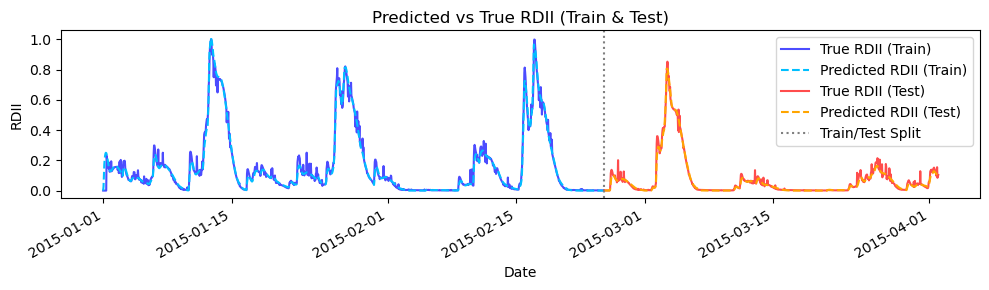

In [8]:
# === Plot predicted vs. true RDII for both training and testing periods ===
plt.figure(figsize=(10, 3))

# --- Training set ---
plt.plot(train_time, rdii_train, label="True RDII (Train)", alpha=0.7, color="blue")
plt.plot(train_time, pred_train, label="Predicted RDII (Train)", linestyle="--", color="deepskyblue")

# --- Testing set ---
plt.plot(test_time, rdii_test, label="True RDII (Test)", alpha=0.7, color="red")
plt.plot(test_time, pred_test, label="Predicted RDII (Test)", linestyle="--", color="orange")

# --- Vertical split line marking transition from training to testing ---
plt.axvline(train_time[-1], color='gray', linestyle=':', label='Train/Test Split')

# --- Axis & layout settings ---
plt.xlabel("Date")
plt.ylabel("RDII")
plt.title("Predicted vs True RDII (Train & Test)")
plt.legend()
plt.gcf().autofmt_xdate()  # Automatically format x-axis date labels
plt.tight_layout()
plt.show()

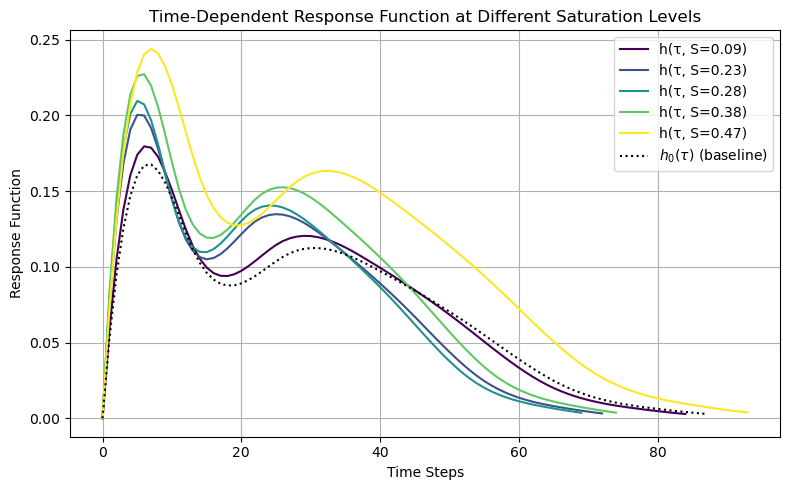

In [9]:
# === Visualize dynamic response functions under varying saturation levels ===
# This plot demonstrates how the model’s response function h(τ, S) adapts to different saturation levels S(t),
# which vary over time depending on rainfall history. It highlights the model's ability to reflect
# physical behavior such as delayed or attenuated responses under wetter conditions.
#
# The full rainfall time series (train + test) is used to compute a wide range of S(t),
# ensuring representative response curves across low to high saturation scenarios.

rainfall = np.concatenate([rainfall_train, rainfall_test])  # Combine for full S(t) coverage

plot_response_at_saturation_levels(
    param_dict=param_dict,                          # Fitted model parameters
    rainfall=rainfall,                              # Full rainfall series to compute S(t)
    compute_kappa_fn=compute_kappa,                 # Time-stretch function κ(S)
    time_dependent_response_fn=time_dependent_response  # Amplitude/time-adjusted response h(τ, S)
)
